In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns

In [66]:
# Global variables
SNAPSHOT_DATE = '2042-06-22'

def non_zero_count(series):
    return (series > 0).sum()

# Data preprocessing

In [7]:
# Importing the dataset
merchants = pd.read_excel('data/raw/merchants.xlsx')
payments = pd.read_excel('data/raw/payments.xlsx')
print(merchants.columns)
print(payments.columns)

Index(['merchant', 'industry', 'first_charge_date', 'country',
       'business_size'],
      dtype='object')
Index(['date', 'merchant', 'subscription_volume', 'checkout_volume',
       'payment_link_volume', 'total_volume'],
      dtype='object')


In [76]:
# '0.0' is the mssing value in the dataset
merchants_processed = merchants.replace(0, np.nan)
merchants_processed['first_charge_date'] = pd.to_datetime(merchants_processed['first_charge_date'])
print(merchants_processed.shape)
print(merchants_processed.isnull().sum())

# drop the rows with nan values
merchants_processed = merchants_processed.dropna()
print(merchants_processed.shape)
merchant_ids = [str(id) for id in merchants_processed['merchant'].values]
print(len(merchant_ids))


(23627, 5)
merchant              8
industry              7
first_charge_date    26
country               0
business_size         0
dtype: int64
(23586, 5)
23586


In [77]:
np.array([8,7,26]) / 23627 * 100
print(merchants['merchant'].nunique())

23620


In [78]:
# payments dataset, only keep the rows with merchant id in merchant_ids
print(payments.shape)
payments_processed = payments.copy()
payments_processed['merchant'] = payments_processed['merchant'].astype(str)
# Convert 'date' to datetime and 'month' to a period
payments_processed['date'] = pd.to_datetime(payments_processed['date'])
payments_processed['month'] = payments_processed['date'].dt.to_period('M')


merchant_first_payment = payments_processed.groupby('merchant')['date'].min().reset_index()
merchant_first_payment.columns = ['merchant', 'first_payment_date']

outcome = payments_processed.groupby('merchant').agg(sub_min = ('subscription_volume', min))
outcome['label'] = (outcome['sub_min'] > 0).astype(int)
outcome = outcome.drop(columns=['sub_min']).reset_index()

merchants_processed = merchants_processed.merge(merchant_first_payment, on='merchant', how='inner')
merchants_processed = merchants_processed.merge(outcome, on='merchant', how='inner')
merchants_processed['signup_days'] = (merchants_processed['first_payment_date'] - merchants_processed['first_charge_date']).dt.days
print(merchants_processed.shape)

payments_processed = payments_processed[payments_processed['merchant'].isin(merchant_ids)]
print(payments_processed.shape)
print(payments_processed['merchant'].nunique())

# payments_processed['date'] = pd.to_datetime(payments_processed['date'])
# payment date range
print(payments_processed['date'].min())
print(payments_processed['date'].max())

(1577887, 6)


/var/folders/8m/ddcyb_xx6hx0nx6yr5msflfm0000gn/T/ipykernel_43963/605219153.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  payments_processed['month'] = payments_processed['date'].dt.to_period('M')


(22897, 8)
(1576631, 7)
23586
2041-05-01 00:00:00+00:00
2042-06-22 00:00:00+00:00


In [79]:
# change the signup_days < 0 to 0
merchants_processed.loc[merchants_processed['signup_days'] < 0, 'signup_days'] = 0

In [80]:
print(merchants_processed['label'].value_counts())
merchants_processed['label'].value_counts() / merchants_processed.shape[0] * 100

0    21007
1     1890
Name: label, dtype: int64


0    91.745644
1     8.254356
Name: label, dtype: float64

## Profile data analysis

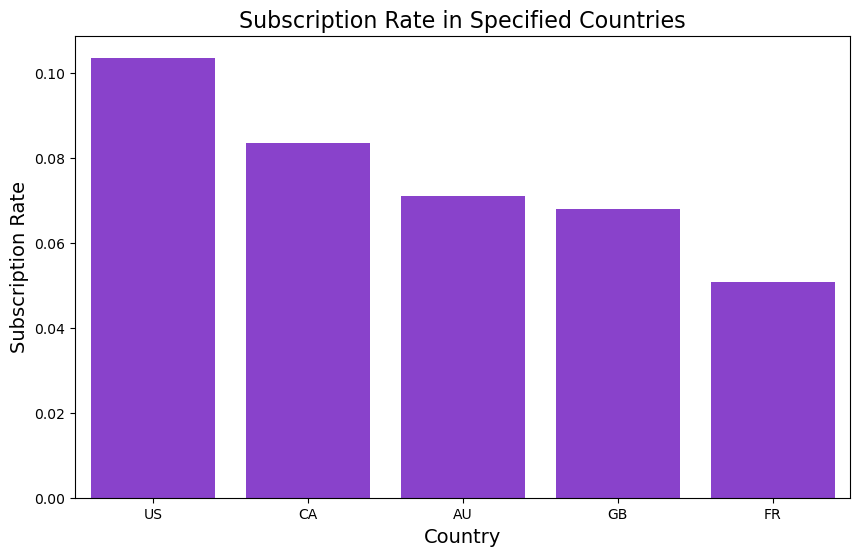

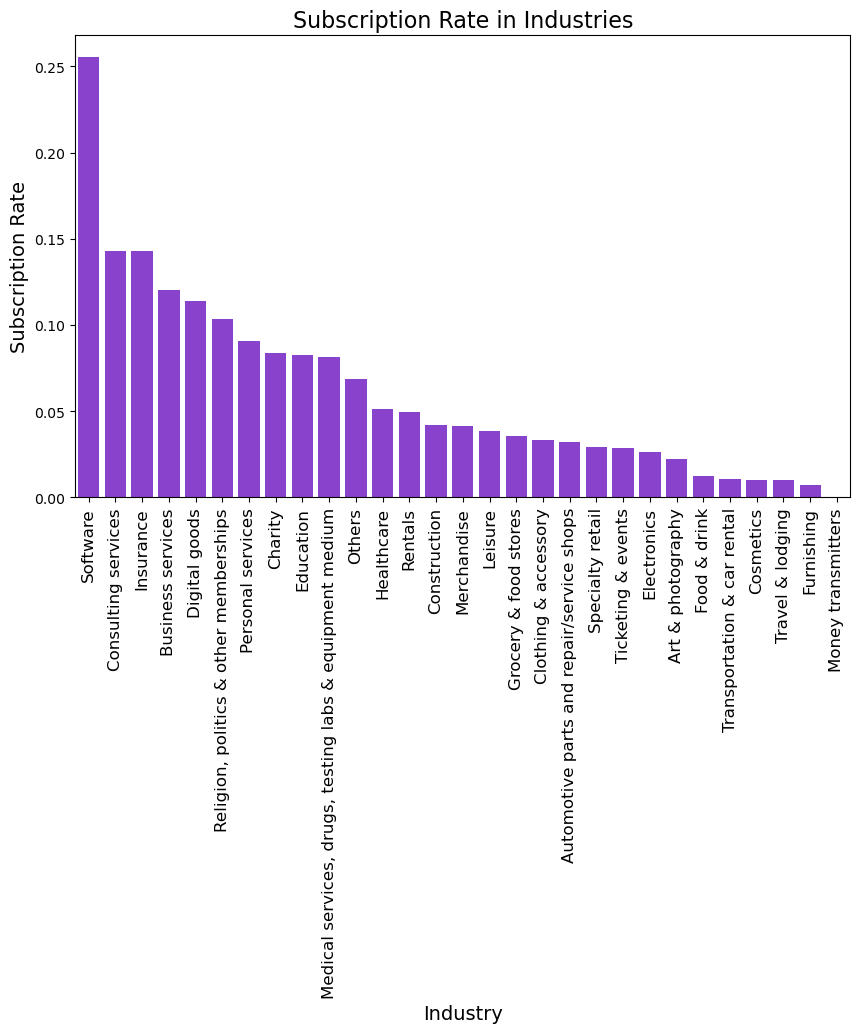

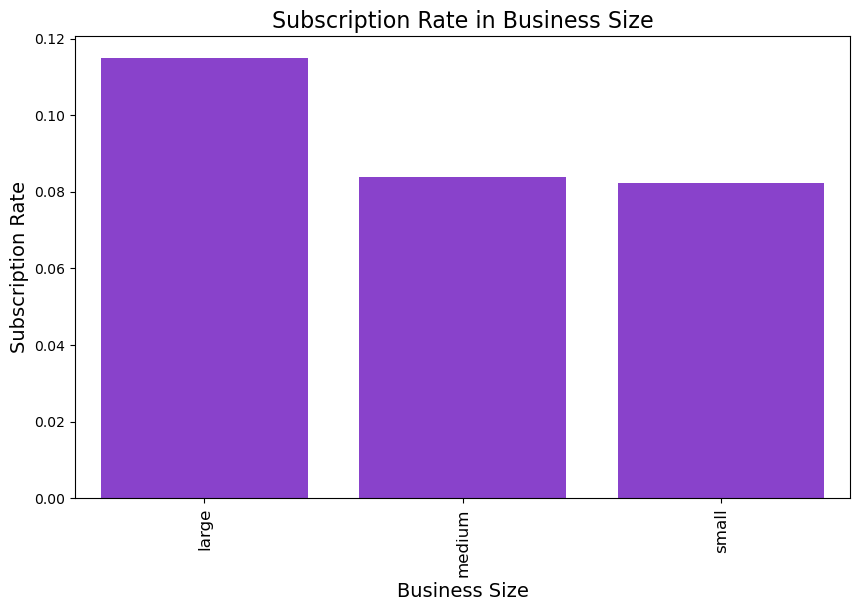

In [178]:
# visualization. subscription rate in countries: US, GB, FR, AU, CA
countries = ['US', 'GB', 'FR', 'AU', 'CA']

# Filter data for specified countries
data = merchants_processed[merchants_processed['country'].isin(countries)]

# Calculate the subscription rate for each country
subscription_rate = data.groupby('country')['label'].mean().sort_values(ascending=False).reset_index()

# Plot data
plt.figure(figsize=(10, 6))
sns.barplot(x='country', y='label', data=subscription_rate, color = 'blueviolet')
plt.title('Subscription Rate in Specified Countries', fontsize=16)
plt.ylabel('Subscription Rate', fontsize=14)
plt.xlabel('Country', fontsize=14)
plt.savefig('figure/subscription_rate_country.png')
plt.show()

# visualization. subscription rate in industries
industry_rate = merchants_processed.groupby('industry')['label'].mean().sort_values(ascending=False).reset_index()
# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='industry', y='label', data=industry_rate, color = 'blueviolet')
plt.title('Subscription Rate in Industries', fontsize=16)
plt.ylabel('Subscription Rate', fontsize=14)
plt.xlabel('Industry', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.savefig('figure/subscription_rate_industry.png', bbox_inches='tight')
plt.show()

# visualization. subscription rate in business size
business_size_rate = merchants_processed.groupby('business_size')['label'].mean().sort_values(ascending=False).reset_index()
# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='business_size', y='label', data=business_size_rate, color = 'blueviolet')
plt.title('Subscription Rate in Business Size', fontsize=16)
plt.ylabel('Subscription Rate', fontsize=14)
plt.xlabel('Business Size', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.savefig('figure/subscription_rate_business_size.png', bbox_inches='tight')
plt.show()

In [160]:
merchants_processed.groupby('country').count()['merchant'].sort_values(ascending=False).head(10)

country
US    8342
GB    3349
FR    1652
AU    1337
CA    1282
ES     896
IT     786
JP     562
DE     492
IE     417
Name: merchant, dtype: int64

## Aggregate Statistics

In [99]:
# Aggregate payments by month for each merchant with sum, mean, max, and custom non-zero count
monthly_subscription_stats = payments_processed.groupby(['merchant', 'month'])['subscription_volume'].\
    agg(
        total_volume='sum',  # Total volume over the month
        # average_volume='mean',  # Average volume per day
        # peak_volume='max',  # Maximum volume in a single day
        active_days=non_zero_count  # Number of days with non-zero subscription
    )
monthly_checkout_stats = payments_processed.groupby(['merchant', 'month'])['checkout_volume'].\
    agg(
        total_volume='sum',  # Total volume over the month
        # average_volume='mean',  # Average volume per day
        # peak_volume='max',  # Maximum volume in a single day
        active_days=non_zero_count  # Number of days with non-zero subscription
    )
monthly_payment_link_stats = payments_processed.groupby(['merchant', 'month'])['payment_link_volume'].\
    agg(
        total_volume='sum',  # Total volume over the month
        # average_volume='mean',  # Average volume per day
        # peak_volume='max',  # Maximum volume in a single day
        active_days=non_zero_count  # Number of days with non-zero subscription
    )
monthly_total_stats = payments_processed.groupby(['merchant', 'month'])['total_volume'].\
    agg(
        total_volume='sum',  # Total volume over the month
        # average_volume='mean',  # Average volume per day
        # peak_volume='max',  # Maximum volume in a single day
        active_days=non_zero_count  # Number of days with non-zero subscription
    )

# Merge the three stats into one dataframe
monthly_stats= pd.merge(monthly_subscription_stats, monthly_checkout_stats, left_index=True, right_index=True, suffixes=('_sub', '_check'))
monthly_stats = pd.merge(monthly_stats, monthly_payment_link_stats, left_index=True, right_index=True, suffixes=('', '_link'))
monthly_stats = pd.merge(monthly_stats, monthly_total_stats, left_index=True, right_index=True, suffixes=('', '_total'))

monthly_stats.reset_index(inplace=True)
# monthly_stats.columns = ['merchant', 'month', 
#                          'sub_total', 'sub_avg', 'sub_peak', 'sub_active_days',
#                          'check_total', 'check_avg', 'check_peak', 'check_active_days',
#                          'link_total', 'link_avg', 'link_peak', 'link_active_days',
#                          'total_total', 'total_avg', 'total_peak', 'total_active_days']

monthly_stats.columns = ['merchant', 'month', 
                         'sub_total', 'sub_active_days',
                         'check_total', 'check_active_days',
                         'link_total', 'link_active_days',
                         'total_total', 'total_active_days']

monthly_stats.head()

total_volume_sub  active_days_sub  total_volume_check  \
merchant month                                                            
00085cb5 2041-05                 0                0              806200   
         2041-06                 0                0              345400   
         2041-07                 0                0             1310400   
         2041-08                 0                0              289700   
         2041-09                 0                0              411800   

                  active_days_check  total_volume  active_days  \
merchant month                                                   
00085cb5 2041-05                  6             0            0   
         2041-06                  2             0            0   
         2041-07                  4             0            0   
         2041-08                  6             0            0   
         2041-09                  4             0            0   

                  total_volume_total  active_days_total  
merchant month                                           
00085cb5 2041-05              806200                  6  
         2041-06              345400                  2  
         2041-07             1310400                  4  
         2041-08              289700                  6  
         2041-09              411800                  4

In [198]:
# have the overall volume, avreage volume, peak volume, and active days for each merchant for sub, check, link, and total

volume_type = ['sub', 'check', 'link', 'total']

monthly_sumarized_stats = monthly_stats.groupby('merchant').agg(
    # sub_total=('sub_total', 'sum'),
    # sub_peak=('sub_total', 'max'),
    # sub_mean = ('sub_total', 'mean'),
    # sub_active_days=('sub_active_days', 'sum'),
    check_total=('check_total', 'sum'),
    check_peak=('check_total', 'max'),
    check_avg = ('check_total', 'mean'),
    check_active_days_total=('check_active_days', 'sum'),
    check_active_days_mean=('check_active_days', 'mean'),
    link_total=('link_total', 'sum'),
    link_peak=('link_total', 'max'),
    link_avg = ('link_total', 'mean'),
    link_active_days_total=('link_active_days', 'sum'),
    link_active_days_mean=('link_active_days', 'mean'),
    total_total=('total_total', 'sum'),
    total_peak=('total_total', 'max'),
    total_avg = ('total_total', 'mean'),
    total_active_days_total=('total_active_days', 'sum'),
    total_active_days_mean=('total_active_days', 'mean')
)

monthly_sumarized_stats.reset_index(inplace=True)
monthly_sumarized_stats.head()

,merchant,check_total,check_peak,check_avg,check_active_days_total,check_active_days_mean,link_total,link_peak,link_avg,link_active_days_total,link_active_days_mean,total_total,total_peak,total_avg,total_active_days_total,total_active_days_mean
0,00085cb5,5160000,1310400,396923.076923,48,3.692308,0,0,0.0,0,0.0,5160000,1310400,396923.076923,48,3.692308
1,000a45ba,0,0,0.000000,0,0.000000,0,0,0.0,0,0.0,142500,45500,14250.000000,37,3.700000
2,000e2c0e,0,0,0.000000,0,0.000000,0,0,0.0,0,0.0,987007,210568,70500.500000,73,5.214286
3,001111d7,0,0,0.000000,0,0.000000,0,0,0.0,0,0.0,1865995,1498948,621998.333333,9,3.000000
4,0015c036,13800,1400,1061.538462,68,5.230769,0,0,0.0,0,0.0,16200,1600,1246.153846,68,5.230769


In [199]:
# have the monthly mean for each merchant
ttest_cols = monthly_sumarized_stats.columns[1:]

monthly_sumarized_stats = monthly_sumarized_stats.merge(merchants_processed[['merchant', 'label']], on='merchant', how='inner')

# t-test for each column, save in a dataframe
ttest_df = pd.DataFrame(columns=['feature', 'p_value', 'diff_mean'])
for col in ttest_cols:
    ttest = ttest_ind(monthly_sumarized_stats[monthly_sumarized_stats['label']==0][col], 
                      monthly_sumarized_stats[monthly_sumarized_stats['label']==1][col],
                      equal_var=False)
    temp_df = pd.DataFrame({'feature': [col], 'p_value': round(ttest[1], 3), 'diff_mean': round(monthly_sumarized_stats[monthly_sumarized_stats['label']==1][col].mean() - monthly_sumarized_stats[monthly_sumarized_stats['label']==0][col].mean(), 3)})
    ttest_df = pd.concat([ttest_df, temp_df], ignore_index=True)

ttest_df.to_csv('data/processed/ttest_aggregate_stats.csv', index=False)


## Trends and Changes
Monthly growth rate

In [200]:
monthly_stats.sort_values(by=['merchant', 'month'], inplace=True)
for product in ['check', 'link', 'total']:
    monthly_stats[f'{product}_prev_total'] = monthly_stats.groupby('merchant')[f'{product}_total'].shift(1)
    # initialize the first month growth rate to 0
    monthly_stats[f'{product}_growth_rate'] = 0

    # case when previous month total is not 0
    mask = monthly_stats[f'{product}_prev_total'] != 0
    monthly_stats.loc[mask, f'{product}_growth_rate'] = monthly_stats.loc[mask, f'{product}_total'] / monthly_stats.loc[mask, f'{product}_prev_total'] - 1

    # case when previous month total is 0 and current month totol is 0
    mask = (monthly_stats[f'{product}_prev_total'] == 0) & (monthly_stats[f'{product}_total'] == 0)
    monthly_stats.loc[mask, f'{product}_growth_rate'] = 0

    # case when previous month total is 0 and current month totol is not 0
    mask = (monthly_stats[f'{product}_prev_total'] == 0) & (monthly_stats[f'{product}_total'] != 0)
    monthly_stats.loc[mask, f'{product}_growth_rate'] = 1

# Drop the columns for previous month's total volumes as they are no longer needed
monthly_stats.drop(columns=[f'{product}_prev_total' for product in ['check', 'link', 'total']], inplace=True)

# Now monthly_stats includes the growth rate columns
growth_stats = monthly_stats.groupby('merchant').agg(
    check_growth_rate=('check_growth_rate', 'mean'),
    link_growth_rate=('link_growth_rate', 'mean'),
    total_growth_rate=('total_growth_rate', 'mean')
)
growth_stats = growth_stats.merge(merchants_processed[['merchant', 'label']], on='merchant', how='right')
# fill the nan with 0
growth_stats.fillna(0, inplace=True)
print(growth_stats.head())
# print(monthly_stats[['merchant', 'month',
#                      'check_total', 'check_growth_rate', 
#                      'link_total', 'link_growth_rate', 
#                      'total_total', 'total_growth_rate']].head())

   merchant  check_growth_rate  link_growth_rate  total_growth_rate  label
0  5d03e714           0.000000               0.0           0.555205      0
1  da22f154           0.000000               0.0           0.022132      0
2  687eebc8           0.000000               0.0           0.060220      1
3  de478470           0.000000               0.0           0.019436      1
4  1e719b8a           7.757137               0.0           7.757137      0


In [201]:
# t-test for each column, save in a dataframe
ttest_df = pd.DataFrame(columns=['feature', 'p_value', 'diff_mean'])
for col in ['check_growth_rate', 'link_growth_rate', 'total_growth_rate']:
    ttest = ttest_ind(growth_stats[growth_stats['label']==0][col], 
                      growth_stats[growth_stats['label']==1][col],
                      equal_var=False)
    temp_df = pd.DataFrame({'feature': [col], 'p_value': round(ttest[1], 3), 'diff_mean': round(growth_stats[growth_stats['label']==1][col].mean() - growth_stats[growth_stats['label']==0][col].mean(), 3)})
    ttest_df = pd.concat([ttest_df, temp_df], ignore_index=True)
ttest_df
ttest_df.to_csv('data/processed/ttest_growth_stats.csv', index=False)

## Monthly variation

In [211]:
volume_types = ['check_total', 'link_total', 'total_total']
merchant_month_variation = pd.DataFrame(index = monthly_stats['merchant'].unique())
for volume_type in volume_types:
    # Standard Deviation
    std_col_name = f'{volume_type}_std'
    mean_col_name = f'{volume_type}_mean'
    cv_col_name = f'{volume_type}_cv'

    merchant_grouped = monthly_stats.groupby('merchant')[volume_type]

    merchant_month_variation[std_col_name] = merchant_grouped.std()
    merchant_month_variation[mean_col_name] = merchant_grouped.mean()
    merchant_month_variation[cv_col_name] = merchant_month_variation[std_col_name] / np.where(merchant_month_variation[mean_col_name] == 0, np.nan, merchant_month_variation[mean_col_name])

merchant_month_variation.drop(columns=[f'{volume_type}_mean' for volume_type in volume_types], inplace=True)
merchant_month_variation.reset_index(inplace=True)
merchant_month_variation.fillna(0, inplace=True)
# rename the index column to merchant
merchant_month_variation.rename(columns={'index': 'merchant'}, inplace=True)  
print(merchant_month_variation.head())

   merchant  check_total_std  check_total_cv  link_total_std  link_total_cv  \
0  00085cb5    351106.292438        0.884570             0.0            0.0   
1  000a45ba         0.000000        0.000000             0.0            0.0   
2  000e2c0e         0.000000        0.000000             0.0            0.0   
3  001111d7         0.000000        0.000000             0.0            0.0   
4  0015c036       287.339699        0.270682             0.0            0.0   

   total_total_std  total_total_cv  
0    351106.292438        0.884570  
1     15089.087300        1.058883  
2     47828.360918        0.678412  
3    781244.260907        1.256023  
4       338.170038        0.271371  


## Lasted 2 months engagement and Frequency
- Number of active days in the last 2 months
- Frequecny of transactions in the last 2 months

In [212]:
payment_last_2month = payments_processed[payments_processed['month'] >= '2042-05']

In [217]:
active_days = payment_last_2month[payment_last_2month['total_volume'] > 0].groupby('merchant')['date'].nunique()
payment_last_2month.sort_values(by=['merchant', 'date'], inplace=True)
payment_last_2month['day_between'] = payment_last_2month.groupby('merchant')['date'].diff().dt.days
avg_days_between = payment_last_2month.groupby('merchant')['day_between'].mean()

merchant_activity_stats = pd.DataFrame({
    'merchant': active_days.index,
    'active_days': active_days,
    'avg_days_between': avg_days_between
}).reset_index(drop=True)
merchant_activity_stats['active_days'] = merchant_activity_stats['active_days'].fillna(0)
merchant_activity_stats['avg_days_between'] = merchant_activity_stats['avg_days_between'].fillna(55)
merchant_activity_stats.isnull().sum()

/var/folders/8m/ddcyb_xx6hx0nx6yr5msflfm0000gn/T/ipykernel_43963/3805553392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payment_last_2month.sort_values(by=['merchant', 'date'], inplace=True)
/var/folders/8m/ddcyb_xx6hx0nx6yr5msflfm0000gn/T/ipykernel_43963/3805553392.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payment_last_2month['day_between'] = payment_last_2month.groupby('merchant')['date'].diff().dt.days


merchant            0
active_days         0
avg_days_between    0
dtype: int64

## Merge data
merchants + aggregate statistics + trends and changes + monthly variation + lasted 2 months engagement and frequency

In [214]:
print(merchants_processed.columns)
print(monthly_sumarized_stats.columns)
print(growth_stats.columns)
print(merchant_month_variation.columns)
print(merchant_activity_stats.columns)

Index(['merchant', 'industry', 'first_charge_date', 'country', 'business_size',
       'first_payment_date', 'label', 'signup_days'],
      dtype='object')
Index(['merchant', 'check_total', 'check_peak', 'check_avg',
       'check_active_days_total', 'check_active_days_mean', 'link_total',
       'link_peak', 'link_avg', 'link_active_days_total',
       'link_active_days_mean', 'total_total', 'total_peak', 'total_avg',
       'total_active_days_total', 'total_active_days_mean', 'label'],
      dtype='object')
Index(['merchant', 'check_growth_rate', 'link_growth_rate',
       'total_growth_rate', 'label'],
      dtype='object')
Index(['merchant', 'check_total_std', 'check_total_cv', 'link_total_std',
       'link_total_cv', 'total_total_std', 'total_total_cv'],
      dtype='object')
Index(['merchant', 'active_days', 'avg_days_between'], dtype='object')


In [215]:
data = merchants_processed.merge(monthly_sumarized_stats.drop('label', axis=1), on='merchant', how='left')
data = data.merge(merchant_month_variation, on='merchant', how='left')
data = data.merge(growth_stats.drop('label', axis=1), on='merchant', how='left')
data = data.merge(merchant_activity_stats, on='merchant', how='left')
data.to_csv('data/processed/merchant_data.csv', index=False)

In [218]:
# t-test for each column, save in a dataframe
ttest_df = pd.DataFrame(columns=['feature', 'p_value', 'diff_mean'])
# not having colums ['merchant', 'label', 'first_charge_date', 'first_payment_date']
cols = data.columns
cols = cols.drop(['merchant', 'label', 'first_charge_date', 'industry', 'country','business_size', 'first_payment_date'])

for col in cols:
    ttest = ttest_ind(data[data['label']==0][col], 
                      data[data['label']==1][col],
                      equal_var=False)
    temp_df = pd.DataFrame({'feature': [col], 'p_value': round(ttest[1], 3), 'diff_mean': round(data[data['label']==1][col].mean() - data[data['label']==0][col].mean(), 3)})
    ttest_df = pd.concat([ttest_df, temp_df], ignore_index=True)
ttest_df
ttest_df.to_csv('data/processed/ttest_merchant_data.csv', index=False)